## Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs."

## Data

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats # statistic library
sns.set(style="white")
sns.set_palette("Paired")
# sns.set_palette("Set2")
import warnings
warnings.filterwarnings('ignore')

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold, cross_validate


#Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Count'] = df.apply(lambda x: x.count()).values
    summary['Uniques'] = df.nunique().values
    summary['Missing'] = df.isnull().sum().values    
    summary['Pct Missing'] = (df.isnull().sum().values/ df.shape[0]).round(3)*100
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2) 
    
    # Sort the table by percentage of missing descending
    summary = summary.sort_values(by='Pct Missing',ascending=False)
    
    return summary

In [6]:
# make general plots to examine each feature
def plot_var(col_name,continuous,df):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12,4))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)

          
    # plot2: bar plot of the variable grouped by churned or not
    if continuous:
        sns.boxplot(x=col_name, y='Churn', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Churn')
    else:
        df.groupby(col_name)['Churn'].value_counts(normalize=True).rename("proportion").reset_index().pivot_table(index=col_name,columns="Churn",values="proportion").plot(ax=ax2,kind='bar', width = 0.2, stacked = True,rot = 0)
#         sns.barplot(x=churn_rates.index, y=churn_rates.values, saturation=1, ax=ax2,stacked=True)
#         ax2.set_ylabel('Fraction churned')
#         ax2.set_title('churned Rate by ' + col_name)
#         ax2.set_xlabel(col_name)
        
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'Churn', height=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
#     else:        
#         fig = plt.figure(figsize=(10,4))
#         sns.countplot(x=col_name, hue='Churn', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

In [7]:
def plot_categorical(feature,df,hue=None,ax=None):
    '''plot counts by different category'''
    sns.countplot(df[feature],hue=hue,ax=ax)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major')
    plt.show()

## 1. Data Exploration

In [8]:
resumetable(data)

Dataset Shape: (7043, 21)


,Name,dtypes,Count,Uniques,Missing,Pct Missing,First Value,Second Value,Third Value,Entropy
0,customerID,object,7043,7043,0,0.0,7590-VHVEG,5575-GNVDE,3668-QPYBK,3.85
11,DeviceProtection,object,7043,3,0,0.0,No,Yes,No,0.46
19,TotalCharges,object,7043,6531,0,0.0,29.85,1889.5,108.15,3.80
18,MonthlyCharges,float64,7043,1585,0,0.0,29.85,56.95,53.85,3.02
17,PaymentMethod,object,7043,4,0,0.0,Electronic check,Mailed check,Mailed check,0.59
16,PaperlessBilling,object,7043,2,0,0.0,Yes,No,Yes,0.29
15,Contract,object,7043,3,0,0.0,Month-to-month,One year,Month-to-month,0.43
14,StreamingMovies,object,7043,3,0,0.0,No,No,No,0.46
13,StreamingTV,object,7043,3,0,0.0,No,No,No,0.46
12,TechSupport,object,7043,3,0,0.0,No,No,No,0.45


### 1.1 Data Cleaning

In [9]:
df = data.copy()
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges.isnull().sum()

11

In [10]:
df[df.TotalCharges.isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


It looks like for customers who have tenure=0, the totalcharges is nan, which maybe because they didn't reach their 1st billing cycle. 

And they all didn't churn. So we can replace null value with 0. 

In [11]:
# data.dropna(inplace=True)
df.TotalCharges = df.TotalCharges.fillna(0).astype('float64')

In [12]:
df.drop(['customerID'],axis=1,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [14]:
# num_var = [x for x in df.columns if df[x].dtype=='int64' or df[x].dtype=='float64']
num_var = ['tenure','MonthlyCharges','TotalCharges']
char_var=[x for x in df.columns if x not in num_var]
char_var.remove('Churn')

for var in char_var:
    df[var] = df[var].astype('category')

### 1.2 Understand the feature and the target

#### 1.2.1 Dependent Variable

In [15]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

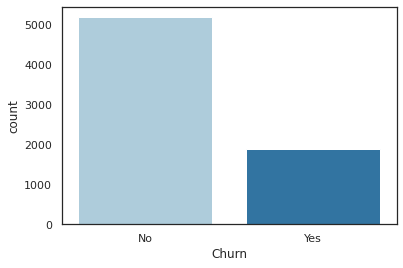

In [16]:
plot_categorical("Churn",df)

In [17]:
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

Data is not very imbalanced

#### 1.2.2 Demographic Features

#### what questions we could ask?
- female/male more likely to churn?
- if senior or not has an impact?
- if bigger family less likely to churn?

In [19]:
demog_var = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

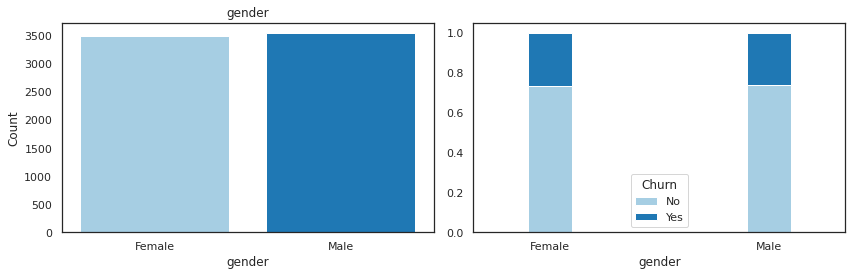

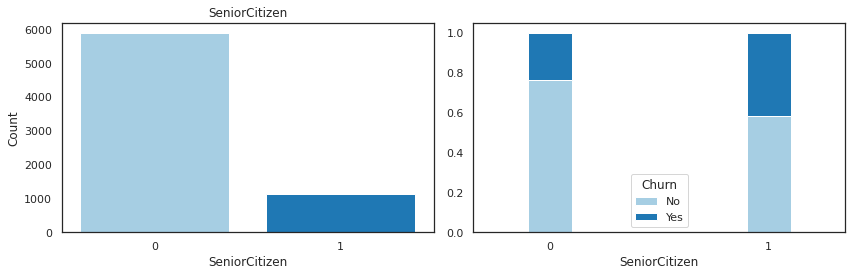

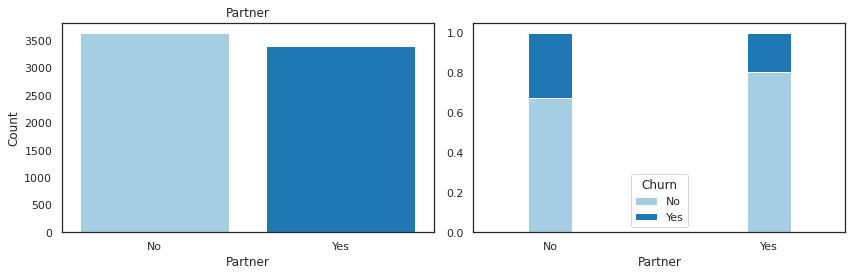

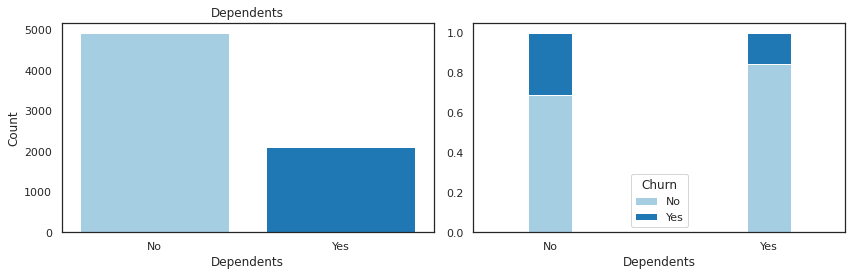

In [20]:
for i in demog_var:
    plot_var(i,continuous=False,df=df)

- Female/male is ~50/50 and there's no significant difference between churn rate of these 2 population. we can drop gender.
- ~1/7 customers are senior and senior customers are more likely to churn.
- customers don't have partner or dependents are more likely to churn, which means people with family are relatively stable

#### 1.2.3 Customer Account Information

In [22]:
customer_acc_info = ['tenure','Contract','PaymentMethod','PaperlessBilling','MonthlyCharges','TotalCharges']

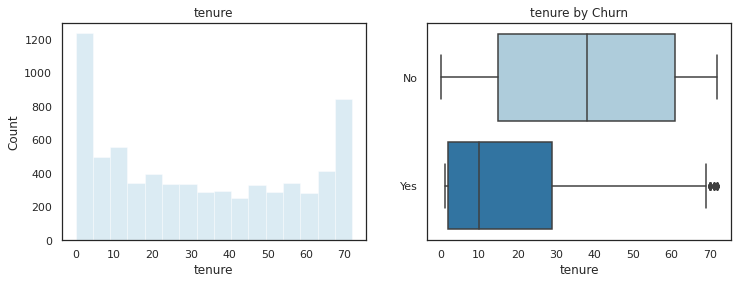

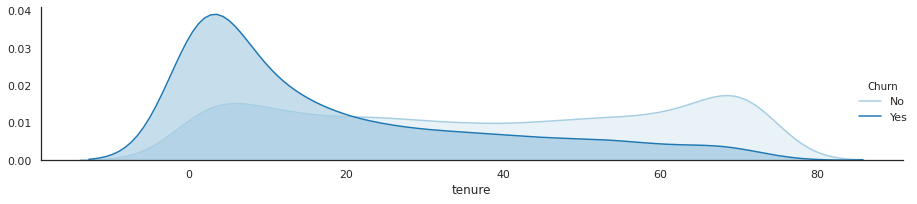

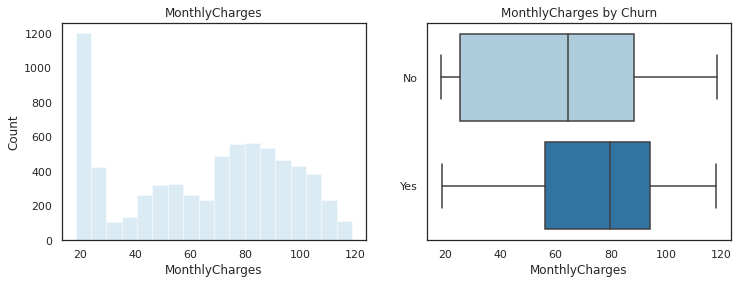

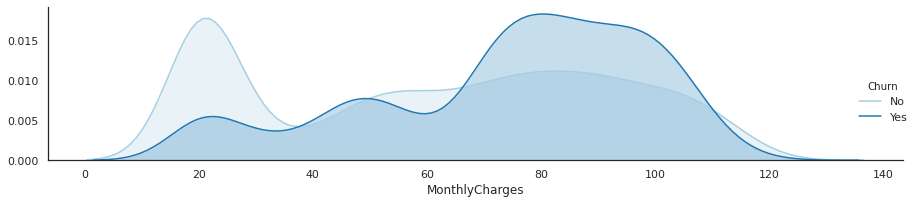

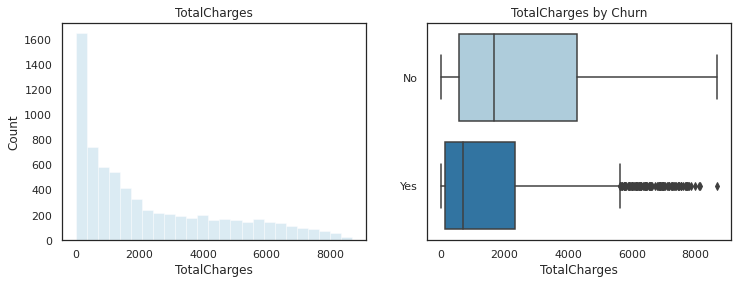

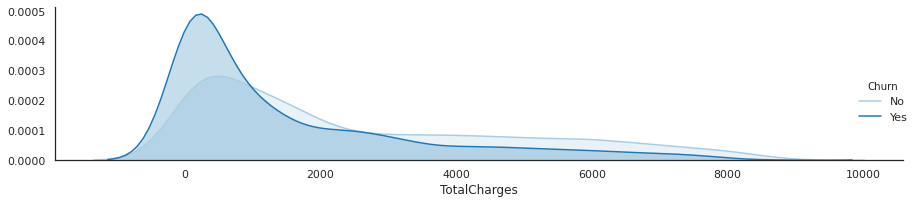

In [23]:
for i in num_var:
    plot_var(i, continuous=True,df=df)

In [24]:
df[['MonthlyCharges','tenure','Churn']].groupby('Churn').mean()

,MonthlyCharges,tenure
Churn,,
No,61.265124,37.569965
Yes,74.441332,17.979133


In [25]:
df[['TotalCharges','tenure','Churn']].groupby('Churn').mean()

,TotalCharges,tenure
Churn,,
No,2549.911442,37.569965
Yes,1531.796094,17.979133


- tenure and monthlycharges could separate churn vs. no-churn. total charges are the multiplacation of these 2 features so we could drop.
- churned customers are more likely to have very short tennure and relatively high monthly charges. => may related to the service they used and is the potential painpoinnt
- customers are more likely to churn with monthly charges > 70; a big part of no-churn customers have monthly charges around 20. => relatively large monthly charges may lead customers churn

In [26]:
cat_var = [x for x in customer_acc_info if x not in num_var]
cat_var

['Contract', 'PaymentMethod', 'PaperlessBilling']

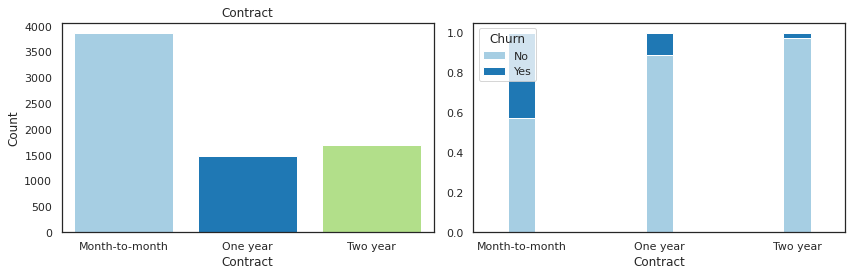

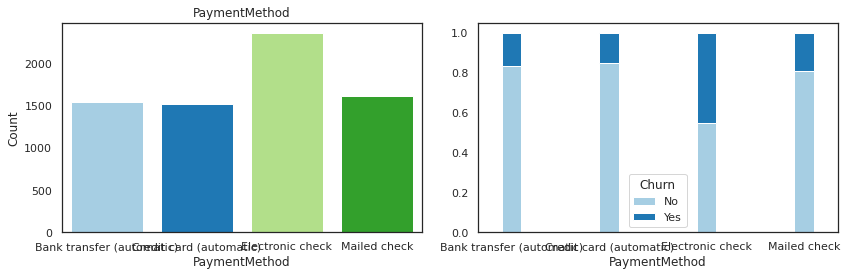

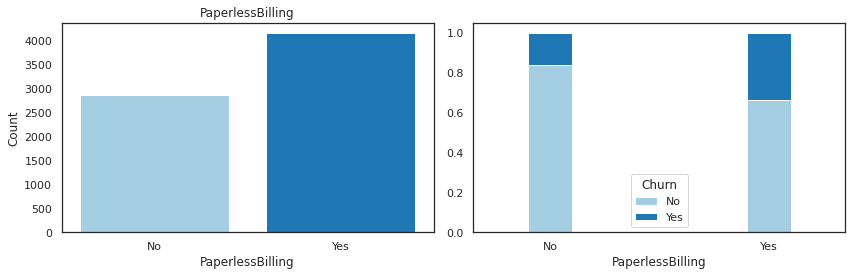

In [27]:
for feature in cat_var:
    plot_var(feature,continuous=False,df=df)

for churned customers, most of them signed month-to-month contract, electronic check and paperlessbiling.

In [28]:
df[['Contract','tenure','Churn']].groupby(['Churn','Contract']).mean()

tenure
Churn Contract                 
No    Month-to-month  21.033333
      One year        41.674063
      Two year        56.602914
Yes   Month-to-month  14.016918
      One year        44.963855
      Two year        61.270833

- month to month contract are more likely to churn since it's easier to change one's mind
- pay by Electronic check are more likely to churn cause it's harder to operate
- enrolled in paperlessbilling are more likely to churn since they see the bill immediately

#### 1.2.4 Services Enrolled

In [30]:
services = ["PhoneService","MultipleLines","InternetService",'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

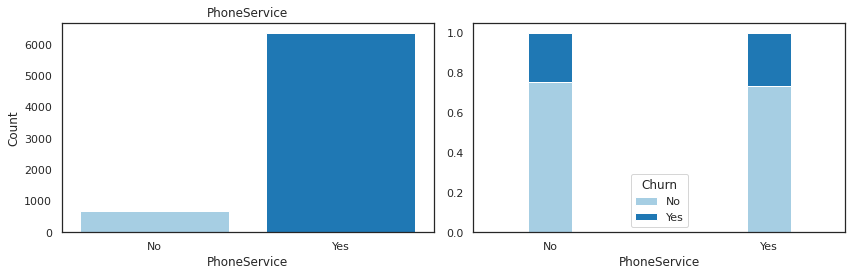

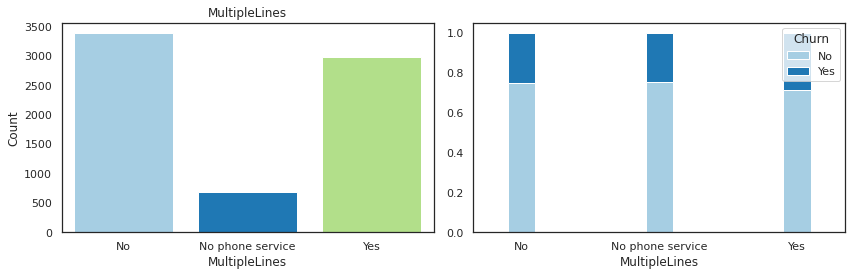

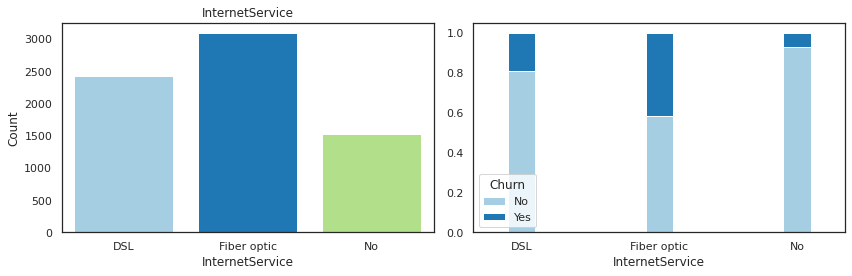

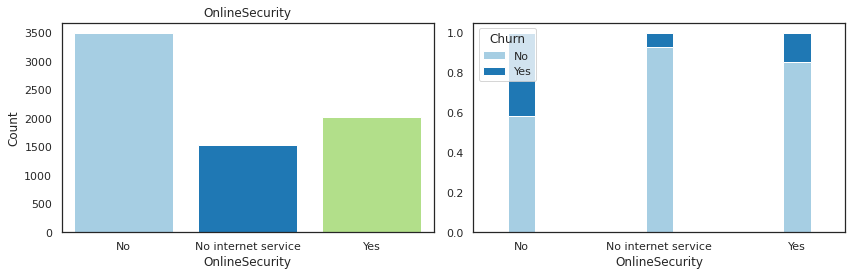

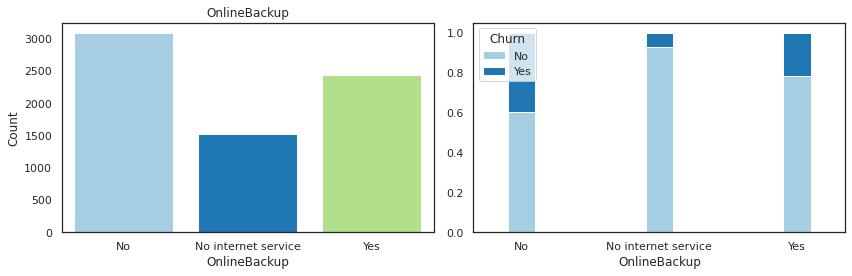

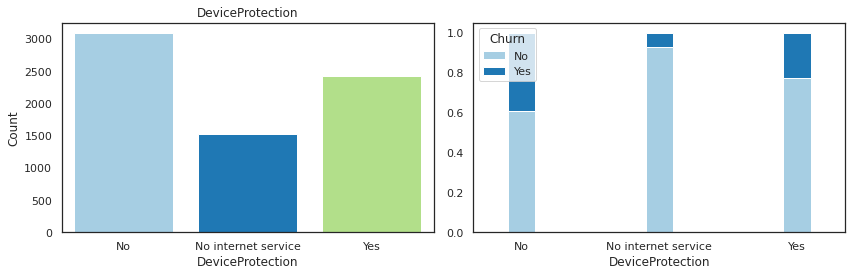

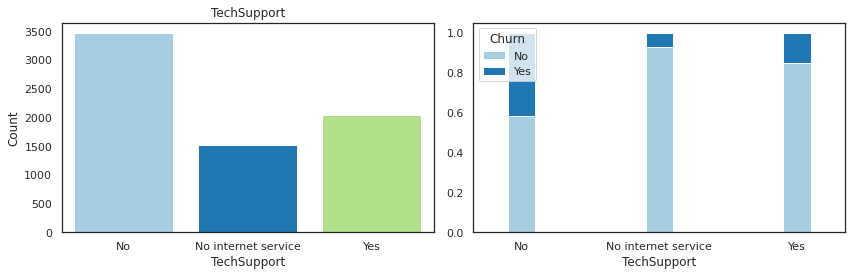

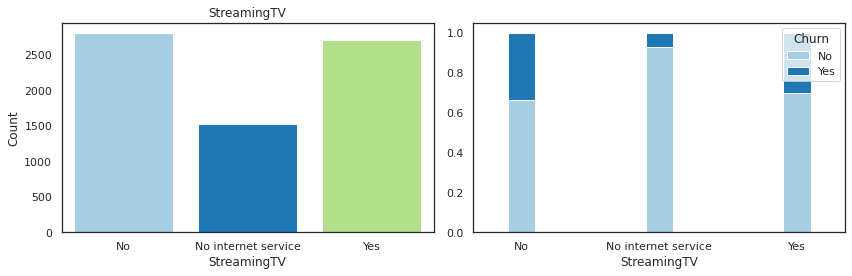

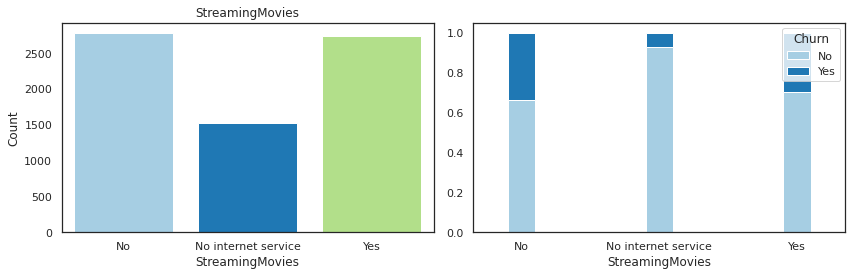

In [31]:
for feature in services:
    plot_var(feature,continuous=False,df=df)

In [32]:
df[['InternetService','MonthlyCharges']].groupby('InternetService').mean()

,MonthlyCharges
InternetService,
DSL,58.102169
Fiber optic,91.500129
No,21.079194


In [33]:
df[['PhoneService','MultipleLines','Churn']].groupby(['Churn','MultipleLines']).count()

PhoneService
Churn MultipleLines                 
No    No                        2541
      No phone service           512
      Yes                       2121
Yes   No                         849
      No phone service           170
      Yes                        850

- most of the customers enrolled phone service and churn rate is indifferent between churn/no-churn population. so drop it. also multiplelines already include this info.
- customers enrolled in internet service with fiber optic have very high churn rate with higher monthly charges => this maybe the reason
- customers didn't enroll in other services have a high churn rate. 

### EDA Summary

- In general, 27% customers churned, not very significant imbalance.
- Demographic level: senior customers more likely to churn. customers don't have partner and dependents are more likely to churn.
- Customer Account level: churned customers have shorter tenure,smaller total charges, month-to-month contract,pay with electronic check, and larger monthly charges
- Service level: customers enrolled internet service with fiber optic are more likely to churn; customers didn't enroll in multiple services are more likely to churn

## 2. Feature Preprocessing

In [34]:
df_clean = df.copy()
df_clean = df_clean.drop(['PhoneService','gender','TotalCharges'],axis=1)
df_clean = df_clean.replace("No phone service","No")
df_clean = df_clean.replace("No internet service","No")

In [35]:
df_clean.Churn = df_clean.Churn.map({'No':0, 'Yes':1})
char_var = [x for x in df_clean.columns if x in char_var]

- Apply Label Encoder to categorical features which are binary
- Apply get_dummies() to categorical features which have multiple values

In [36]:
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns
for column in df_clean.columns:
    if df_clean[column].dtype.name == 'category' :
        if df_clean[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_clean[column] = le.fit_transform(df_clean[column]) 
        else:
            dummy_columns.append(column)
#apply get dummies for selected columns
df_dummy = pd.get_dummies(data = df_clean,columns = dummy_columns, prefix=dummy_columns)

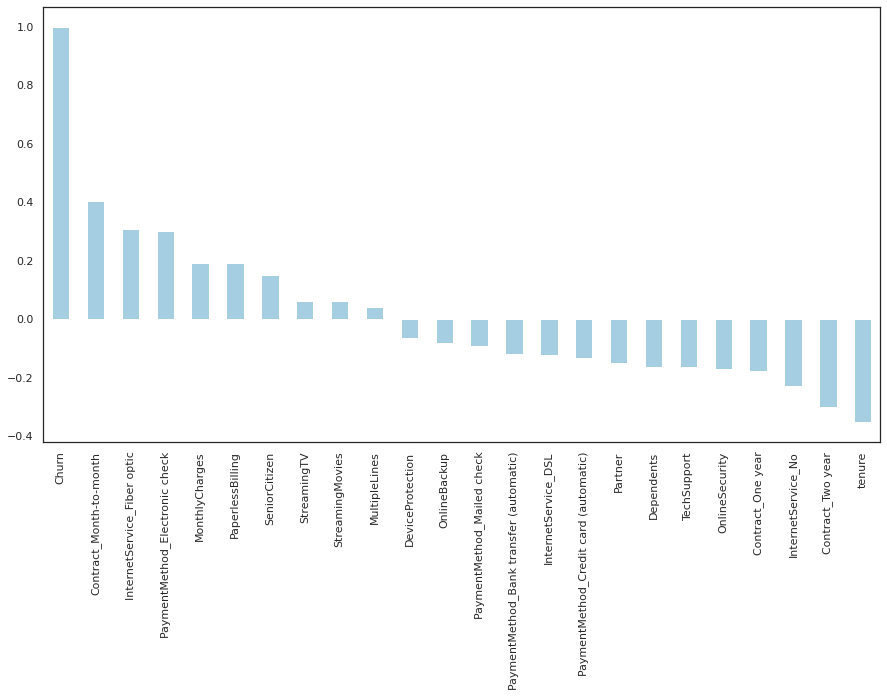

In [37]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummy.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

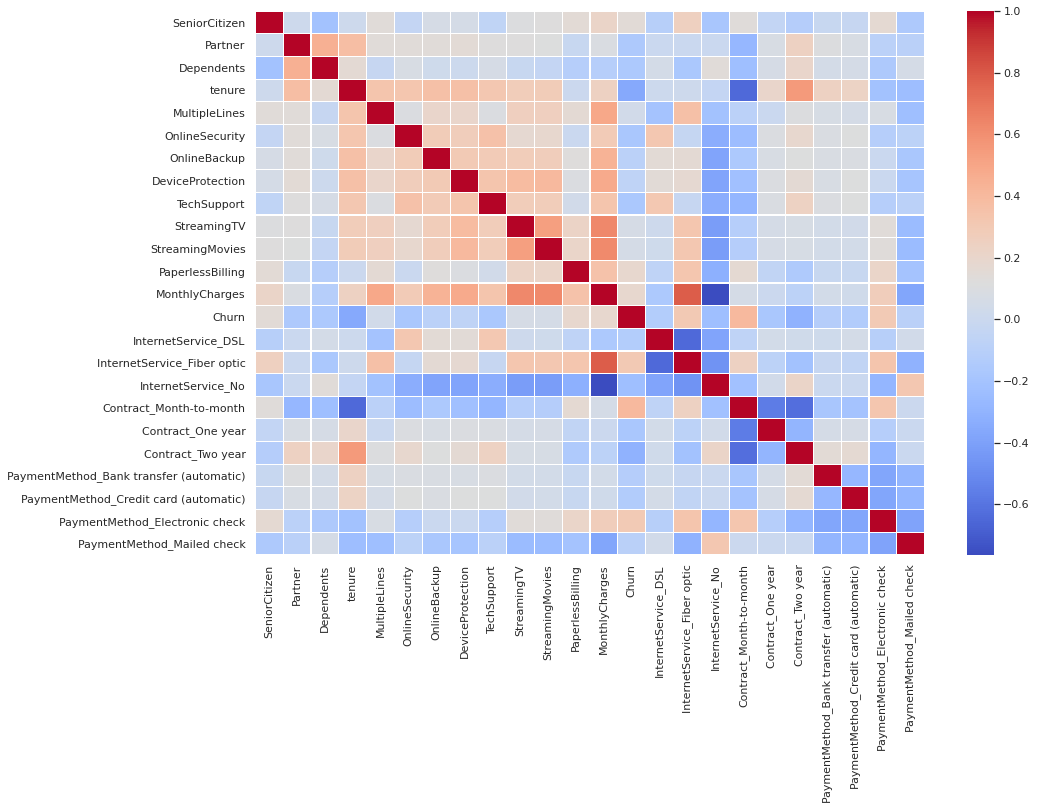

In [38]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df_dummy.corr(), #xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="coolwarm") #,annot=True, fmt = ".2f"

In [39]:
X = df_dummy.drop(['Churn'], axis=1)
y = df_dummy.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,random_state=42)

In [40]:
# Standardize data after train test split
# Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X.columns)
#scaled_test = (test - train_mean) / train_std_deviation
#The reason is that we want to pretend that the test data is “new, unseen data.” 
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X.columns)

In [41]:
# feature selection
LRmodel_l1 = LogisticRegression(penalty="l1",solver='liblinear')
LRmodel_l1.fit(X_train, y_train)
LRmodel_l1.coef_[0]
print("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]),X_train.columns), key=lambda kv:(-abs(kv[0]),kv[1])):
    print(v + ": " + str(k))

Logistic Regression (L1) Coefficients
tenure: -0.796
InternetService_Fiber optic: 0.7257
MonthlyCharges: -0.7221
InternetService_No: -0.573
Contract_Month-to-month: 0.3254
Contract_Two year: -0.3228
StreamingMovies: 0.2811
StreamingTV: 0.2287
MultipleLines: 0.1962
PaperlessBilling: 0.1619
PaymentMethod_Electronic check: 0.1519
OnlineSecurity: -0.1312
TechSupport: -0.0929
Dependents: -0.0773
SeniorCitizen: 0.06
DeviceProtection: 0.0583
PaymentMethod_Credit card (automatic): -0.0373
Partner: 0.0248
OnlineBackup: -0.0077
PaymentMethod_Bank transfer (automatic): -0.0017
Contract_One year: 0.0
InternetService_DSL: 0.0
PaymentMethod_Mailed check: 0.0


In [45]:
drop_cols = ['Contract_One year','DeviceProtection','InternetService_DSL','OnlineBackup'
             ,'Partner','TechSupport','PaymentMethod_Bank transfer (automatic)','PaymentMethod_Mailed check','PaymentMethod_Credit card (automatic)']

In [46]:
X_train = X_train.drop(columns = drop_cols)
X_test = X_test.drop(columns = drop_cols)
print('Training shape: ', X_train.shape)

Training shape:  (5634, 14)


### 3. Model Training and Result Evaluation

- Evaluate and compare the following models using a cross-validated AUROC* score on the training set
- Perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

*For the metrics, both precision and recall of the result are important, as we care about true positives as well as false positives. I like to predict most of the customers that are likely to churn and provide them some special offers but I don't want to bother the ones that actually are not going to stop using the service.

#### 3.1 K-Fold Stratified Cross Validation

k-fold cross-validation is not appropriate for evaluating imbalanced classifiers.It splits into k-folds with a uniform probability distribution.

The solution is to not split the data randomly when using k-fold cross-validation or a train-test split. Specifically, we can split a dataset randomly, although in such a way that maintains the same class distribution in each subset. This is called stratification or stratified sampling and the target variable (y), the class, is used to control the sampling process.

In [47]:
kfold = StratifiedKFold(n_splits=5)

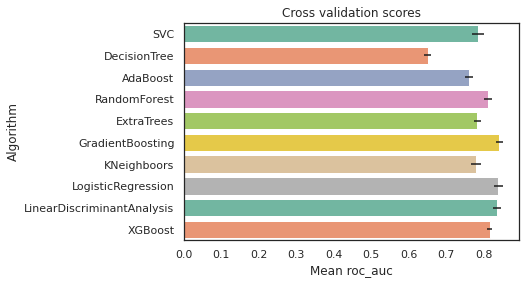

In [48]:
# Test differents algorithms 
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBoost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean roc_auc")
g = g.set_title("Cross validation scores")

I decide to choose: RandomForest, GradientBoosting, logistic Regression and XGBoost, for further fine-tunning and the ensemble modeling

#### 3.2 Hyper-parameter Tuning for Best Models

#### 3.2.1 Random Forest

In [52]:
### Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=42)
rf_param_grid = {
    'max_depth': [4, 8],
    "min_samples_split": range(4,10),
    "min_samples_leaf": range(1,6)
}

grid_rf = GridSearchCV(rf, param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=200,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8], 'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(4, 10)},
             scoring='roc_auc', verbose=1)

In [53]:
rf_best = grid_rf.best_estimator_
# Best score
print('Best Score:', grid_rf.best_score_)
print('Best parameters set: \n', grid_rf.best_params_)

Best Score: 0.8435367783472945
Best parameters set: 
 {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 9}


In [54]:
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)[:,1]

#### 3.2.2 Logistic Regression

In [55]:
### Logistic Regression classifier

lr = LogisticRegression()
C_grid = 0.001*10**(np.arange(0,1.01,0.01)*3)
lr_param_grid  = {
    'penalty': ['l1', 'l2'], 
    'C': C_grid
}

grid_lr = GridSearchCV(lr, lr_param_grid, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([0.001     , 0.00107152, 0.00114815, 0.00123027, 0.00131826,
       0.00141254, 0.00151356, 0.00162181, 0.0017378 , 0.00186209,
       0.00199526, 0.00213796, 0.00229087, 0.00245471, 0.00263027,
       0.00281838, 0.00301995, 0.00323594, 0.00346737, 0.00371535,
       0.00398107, 0.0042658 , 0.00457088, 0.00489779, 0.00524807,
       0.00562341, 0.00...
       0.12589254, 0.13489629, 0.14454398, 0.15488166, 0.16595869,
       0.17782794, 0.19054607, 0.20417379, 0.21877616, 0.23442288,
       0.25118864, 0.26915348, 0.28840315, 0.30902954, 0.33113112,
       0.35481339, 0.3801894 , 0.40738028, 0.43651583, 0.46773514,
       0.50118723, 0.5370318 , 0.57543994, 0.616595  , 0.66069345,
       0.70794578, 0.75857758, 0.81283052, 0.87096359, 0.9332543 ,
       1.        ]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [56]:
lr_best = grid_lr.best_estimator_
# Best score
print('Best Score:', grid_lr.best_score_)
print('Best parameters set: \n', grid_lr.best_params_)

Best Score: 0.8401889999105411
Best parameters set: 
 {'C': 0.8128305161640995, 'penalty': 'l2'}


In [57]:
y_pred_lr = lr_best.predict(X_test)
y_prob_lr = lr_best.predict_proba(X_test)[:,1]

#### 3.2.3 Gradient Boosting

In [58]:
# Gradient boosting tunning
gb = GradientBoostingClassifier(random_state=random_state)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

grid_gb = GridSearchCV(gb,param_grid = gb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_gb.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [59]:
gb_best = grid_gb.best_estimator_
# Best score
print('Best Score:', grid_gb.best_score_)
print('Best parameters set: \n', grid_gb.best_params_)

Best Score: 0.8444508212294686
Best parameters set: 
 {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 100}


In [60]:
y_pred_gb = gb_best.predict(X_test)
y_prob_gb = gb_best.predict_proba(X_test)[:,1]

#### 3.2.4 XGB

In [61]:
# XGboost tunning
xgb = GradientBoostingClassifier(random_state=random_state)

#xgb.get_params().keys()
xgb_param_grid = {
    'learning_rate': [0.025,0.05,0.08,0.1], 
    'max_depth': [3,4,5],
    'subsample': [0.25,0.5,1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid = xgb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   26.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.025, 0.05, 0.08, 0.1],
                         'max_depth': [3, 4, 5],
                         'subsample': [0.25, 0.5, 1.0]},
             scoring='roc_auc', verbose=1)

In [62]:
xgb_best = grid_xgb.best_estimator_
# Best score
print('Best Score:', grid_xgb.best_score_)
print('Best parameters set: \n', grid_xgb.best_params_)

Best Score: 0.8446244807637069
Best parameters set: 
 {'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}


In [63]:
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:,1]

#### 3.3 Comparing the best model

In [64]:
# print a summary of the scores
def print_grid_search_metrics(gs):
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [65]:
print_grid_search_metrics(grid_lr)

Best score: 0.840
Best parameters set:
	C: 0.8128305161640995
	penalty: 'l2'


#### 3.3.1 Plot learning curves
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy. a learning curve shows how error changes as the training set size increases. (It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error)

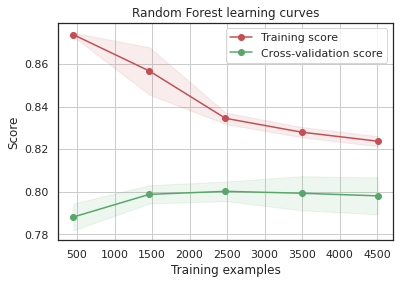

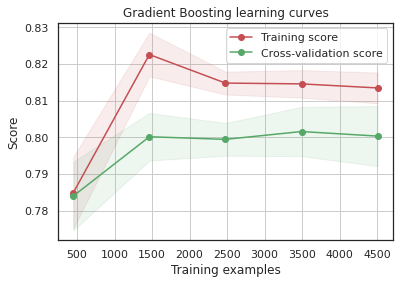

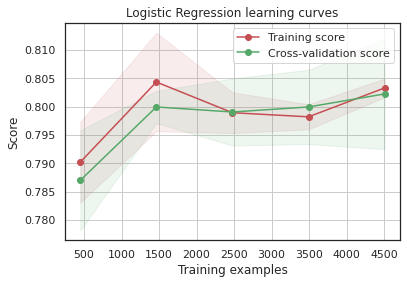

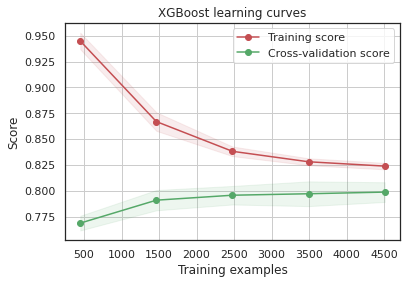

In [81]:
# Plot learning curves

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(grid_rf.best_estimator_,"Random Forest learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_gb.best_estimator_,"Gradient Boosting learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_lr.best_estimator_,"Logistic Regression learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_xgb.best_estimator_,"XGBoost learning curves",X_train,y_train,cv=kfold)

GradientBoosting, Random Forest and XGB tend to overfit the training set. 

#### 3.3.2 Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [67]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

def cal_evaluation(classifier, cm, auc):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2 * precision * recall / (precision + recall)
    print(classifier)
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1 score is " + str(f1))
    print("ROC AUC is " + str(auc))
    return [accuracy,precision, recall,f1,auc]

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    summary_table = pd.DataFrame()
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        summary_table[classifier] = cal_evaluation(classifier, cm, auc)
        plt.figure(figsize=(6,4))
        plt.subplot(111)
        sns.heatmap(cm,annot=True,fmt = "d",linecolor="k",linewidths=3)
        plt.title("CONFUSION MATRIX",fontsize=20)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    summary_table.index = ['accuracy','precision', 'recall','f1','auc']
    return summary_table
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#         cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
#         plt.title('Confusion matrix for {}'.format(classifier))
#         fig.colorbar(cax)
#         ax.set_xticklabels([''] + class_names)
#         ax.set_yticklabels([''] + class_names)
#         plt.xlabel('Predicted')
#         plt.ylabel('True')
#         plt.show()

[0 1]
Gradient Boosting
Accuracy is 0.808374733853797
Precision is 0.6819787985865724
Recall is 0.517426273458445
F1 score is 0.5884146341463414
ROC AUC is 0.8631491506826626


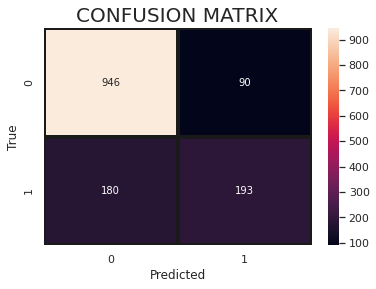

Logisitic Regression
Accuracy is 0.8190205819730305
Precision is 0.6855345911949685
Recall is 0.5844504021447721
F1 score is 0.6309696092619391
ROC AUC is 0.8603478526400777


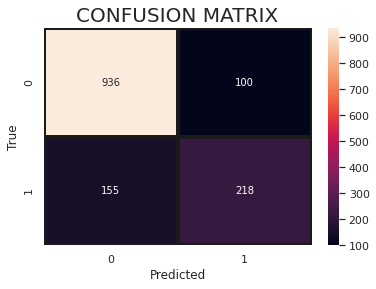

Random Forest
Accuracy is 0.8062455642299503
Precision is 0.6798561151079137
Recall is 0.5067024128686327
F1 score is 0.5806451612903226
ROC AUC is 0.863784456612875


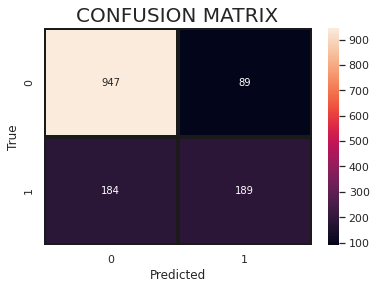

XGBoost Classifier
Accuracy is 0.8112136266855926
Precision is 0.6851211072664359
Recall is 0.5308310991957105
F1 score is 0.5981873111782477
ROC AUC is 0.8625021996335669


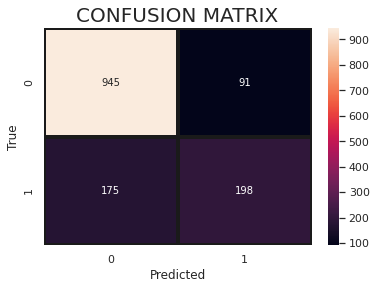

,Gradient Boosting,Logisitic Regression,Random Forest,XGBoost Classifier
accuracy,0.808375,0.819021,0.806246,0.811214
precision,0.681979,0.685535,0.679856,0.685121
recall,0.517426,0.584450,0.506702,0.530831
f1,0.588415,0.630970,0.580645,0.598187
auc,0.863149,0.860348,0.863784,0.862502


In [82]:
%matplotlib inline

y = np.array(y)
class_names = np.unique(y)
print(class_names)

confusion_matrices = [
    ("Gradient Boosting", confusion_matrix(y_test, y_pred_gb), roc_auc_score(y_test, y_prob_gb)),
    ("Logisitic Regression", confusion_matrix(y_test, y_pred_lr), roc_auc_score(y_test, y_prob_lr)),
    ("Random Forest", confusion_matrix(y_test, y_pred_rf), roc_auc_score(y_test, y_prob_rf)),
    ("XGBoost Classifier", confusion_matrix(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb))
    
]

summary_table = draw_confusion_matrices(confusion_matrices)
summary_table

#### 3.3.3 Feature Importance

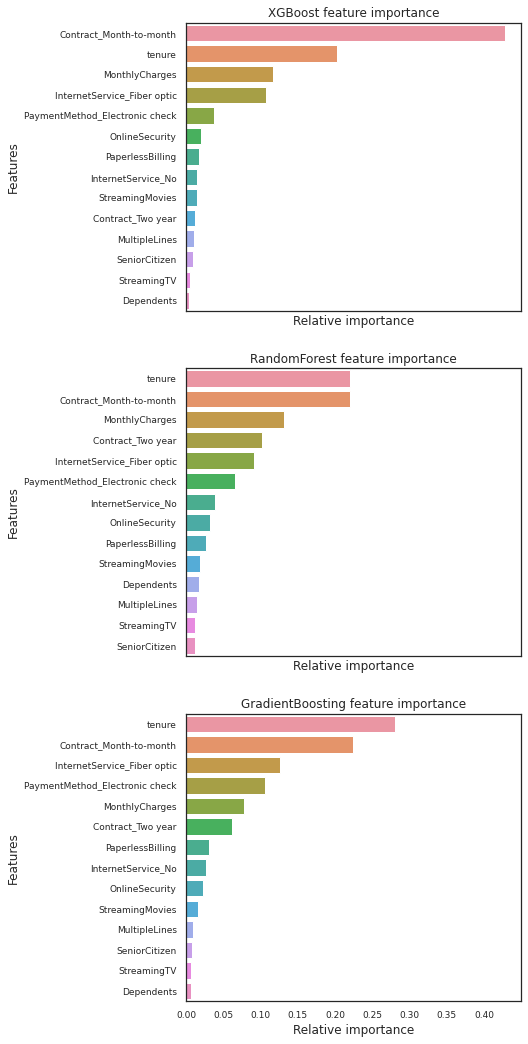

In [83]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(6,18))

names_classifiers = [("XGBoost", xgb_best),("RandomForest",rf_best),("GradientBoosting",gb_best),("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

I plot the feature importance for the 3 tree based classifiers (Random Forest, Gradient Boosting and XGBoost)

The top features are the same among Random Forest, Gradient Boosting and XGB include tenure, contract month-to-month, InternetService_Fiber optic, PaymentMethod_Electronic check, and monthlycharges. We could observe similar pattern using permutation importance in the following plots



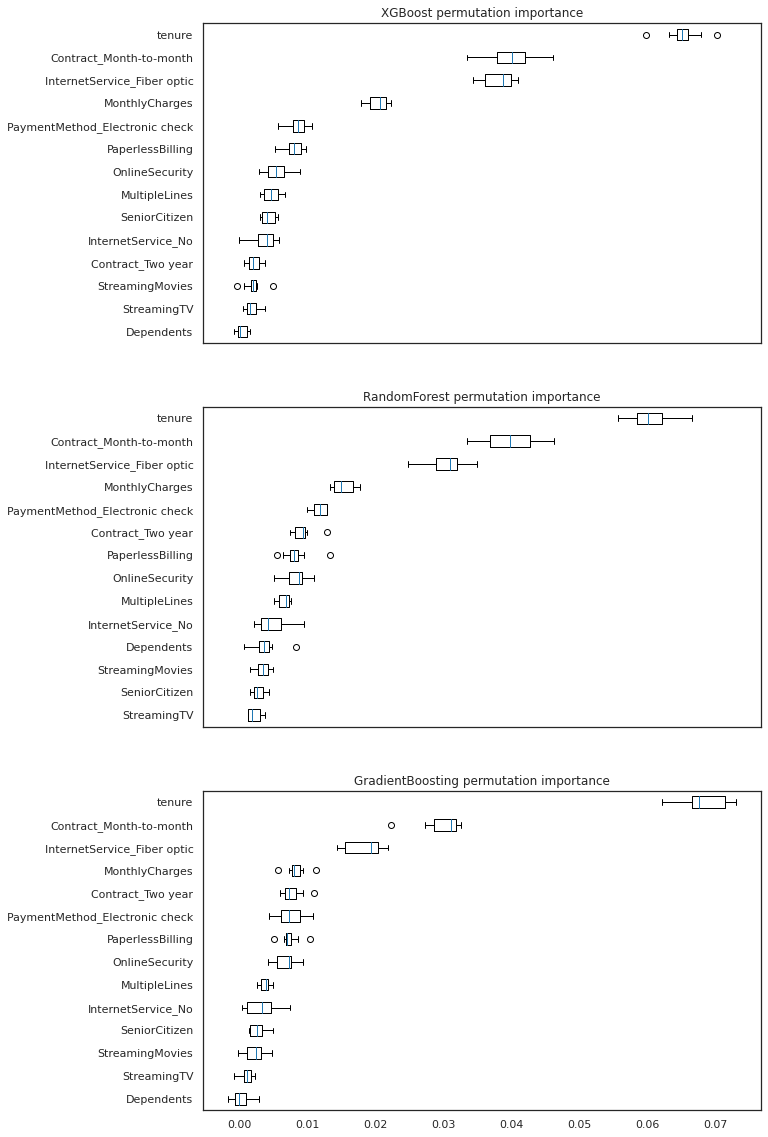

In [70]:
from sklearn.inspection import permutation_importance
#https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(10,20))

names_classifiers = [("XGBoost", xgb_best),("RandomForest",rf_best),("GradientBoosting",gb_best),("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    result = permutation_importance(classifier, X_train, y_train, n_repeats=10,
                                random_state=random_state, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()
    axes[row].boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    axes[row].set_title(name + " permutation importance")
    nclassifier += 1

AxesSubplot(0.125,0.125;0.775x0.755)


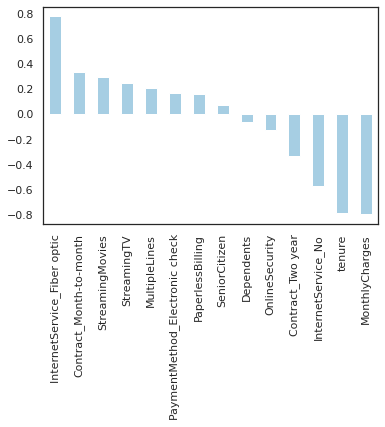

In [71]:
# To get the weights of all the variables
weights = pd.Series(lr_best.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False).plot(kind='bar'))

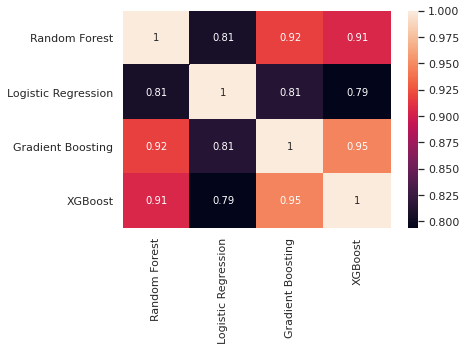

In [85]:
# Concatenate all classifier results

test_rf = pd.Series(rf_best.predict(X_test), name="Random Forest")
test_lr = pd.Series(lr_best.predict(X_test), name="Logistic Regression")
test_gb = pd.Series(gb_best.predict(X_test), name="Gradient Boosting")
test_xgb = pd.Series(xgb_best.predict(X_test), name="XGBoost")


ensemble_results = pd.concat([test_rf, test_lr,test_gb, test_xgb],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

The prediction seems to be quite similar for the 5 classifiers

The 4 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

#### 3.3.4 Ensemble modeling
I use a voting classifier to combine the predictions coming from the 4 classifiers.

I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [86]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('lr',lr_best),
 ('gb',gb_best),('xgb',xgb_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, y_train)

In [87]:
y_pred_voting = votingC.predict(X_test)
y_prob_voting = votingC.predict_proba(X_test)[:,1]

Ensemble modeling
Accuracy is 0.8133427963094393
Precision is 0.6833333333333333
Recall is 0.5495978552278821
F1 score is 0.6092124814264488
ROC AUC is 0.8655959195503432


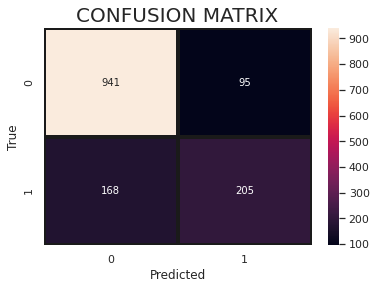

,Ensemble modeling,Gradient Boosting,Logisitic Regression,Random Forest,XGBoost Classifier
accuracy,0.813343,0.808375,0.819021,0.806246,0.811214
precision,0.683333,0.681979,0.685535,0.679856,0.685121
recall,0.549598,0.517426,0.584450,0.506702,0.530831
f1,0.609212,0.588415,0.630970,0.580645,0.598187
auc,0.865596,0.863149,0.860348,0.863784,0.862502


In [88]:
confusion_matrices = [
    ("Ensemble modeling", confusion_matrix(y_test, y_pred_voting), roc_auc_score(y_test, y_prob_voting))   
]
ensemble_summary_table=draw_confusion_matrices(confusion_matrices)
pd.concat([ensemble_summary_table,summary_table],axis=1)

ensemble model has the highest AUC.

#### 3.3.5 Profit Curve
Profit curve - takes into account dollar costs/benefits associated with true positives, false positives, true negatives, and false negatives. A profit curve can help optimize overall profit and help you select the best model and predicted probability threshold. What’s the cost to the company of your model predicts incorrectly? What’s the added value if it predicts correctly? etc.

In [147]:
def plot_profit_curve(model, costbenefit_mat, y_proba, y_test):
    '''
    Plot profit curve.

    INPUTS:
    - model object
    - cost benefit matrix in the same format as the confusion matrix above
    - predicted probabilities
    - actual labels
    '''

    # Profit curve data
    profits = [] # one profit value for each T (threshold)
    thresholds = sorted(y_proba, reverse=True)

    # For each threshold, calculate profit - starting with largest threshold
    for T in thresholds:
        y_pred = (y_proba > T).astype(int)
        [[tn, fp], [fn, tp]]  = confusion_matrix(y_test, y_pred)
        tpr= tp/(tp+fn)
        fpr= fp/(fp+tn)
        fnr= fn/(tp+fn)
        tnr= tn/(fp+tn)
        tp_b=costbenefit_mat[1][1]
        fp_b=costbenefit_mat[0][1]
        fn_b=costbenefit_mat[1][0]
        tn_b=costbenefit_mat[0][0]
        
        prior_p = (tp+fn)/len(y_test)
        profit = prior_p* (tpr*tp_b + fnr*fn_b) + (1-prior_p)*(fpr*fp_b+tnr*tn_b)
        # Calculate total profit for this threshold
#         profit = sum(sum(confusion_mat * costbenefit_mat)) / len(y_test)
        profits.append(profit)

    # Profit curve plot
    max_profit = round(max(profits),2)
    pct_best = profits.index(max(profits))/len(profits)
    print(model,'targer top-ranked', round(pct_best,2),'of customers could get max profit:', max_profit)
    plt.plot(np.linspace(0, 1, len(y_test)), profits, label = '{}, max profit ${} per user'.format(model, max_profit))
    plt.xlabel('Percentage of test instances (decreasing by score)')
    plt.ylabel('Profit')
    plt.title('Profit Curves')
    plt.legend(loc='lower left')



#### Cost benefit matrix

We will assume that if the model predicts that a user will churn, we will spend $150 dollars retaining them (in promotions, marketing, etc.). 

If we successfully identify a customer who will churn and manage to retain them, we will gain in customer lifetime value minus the cost of retaining them ( $2550 - $ 150).

If we predict a customer will not churn but actually churned, we will lost life time value of churned customer $ 1531

In [131]:
costbenefit_mat = np.array([[0, -150],
                          [-1531, 2400]])

XGBoost targer top-ranked 0.75 of customers could get max profit: 545.57
RandomForest targer top-ranked 0.69 of customers could get max profit: 548.4
GradientBoosting targer top-ranked 0.74 of customers could get max profit: 546.21
LogisticRegression targer top-ranked 0.7 of customers could get max profit: 549.81
EnsembleVoting targer top-ranked 0.71 of customers could get max profit: 548.32


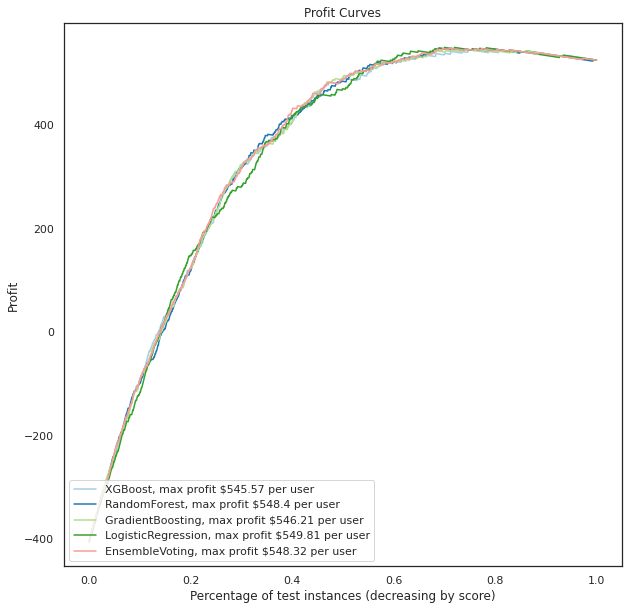

In [149]:
names_classifiers = [("XGBoost", xgb_best),("RandomForest",rf_best),("GradientBoosting",gb_best),("LogisticRegression",lr_best),("EnsembleVoting",votingC)]
plt.figure(figsize=(10, 10))

for x in names_classifiers:
    model_name, model = x[0], x[1]
    y_proba = model.predict_proba(X_test)[:, 1]
    plot_profit_curve(model_name, costbenefit_mat, y_proba, y_test)
plt.show()

Logistic Regression gives us the highest profit per user - $ 549.81 while we target top-ranked seventy percent of customers if we sort customers by prediction score descendingly. 

## Reference
- https://carmenlai.com/2016/11/12/user-churn-prediction-a-machine-learning-workflow.html
- https://github.com/yanxiali/User_Churn_Predictions/blob/master/User_Churn_Prediction.ipynb
- https://github.com/SydneyLauren/Profit-curves-and-xkcd-plotting/blob/master/Profit_Curves.ipynb